# Imports

In [5]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from sklearn.mixture import GaussianMixture
from matplotlib import cm
from sklearn import neighbors, datasets
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
sys.path.append("../src")

# Constants

In [19]:
train_path = "../data/train.csv"
train_not_norm_path = "../data/train_not_normalized.csv"

# Loading data

In [20]:
take_normalized_data = True

In [21]:
def preprocessing_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

In [22]:
if take_normalized_data:
    # Already preprocessed data
    df_data = pd.read_csv(train_path, sep=",")
    X = df_data[df_data.columns.difference(["full_label", 'label'])].values
    
else:
    # Load data not preprocessed and preprocess it
    df_data = pd.read_csv(train_not_norm_path, sep=",")
    X = df_data[df_data.columns.difference(['label'])].values
    X = preprocessing_data(X)

y = df_data["label"].values

# PCA

In [25]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1','principal component 2'])

In [26]:
finalDf = pd.concat([principalDf, df_data[['label']]], axis = 1)

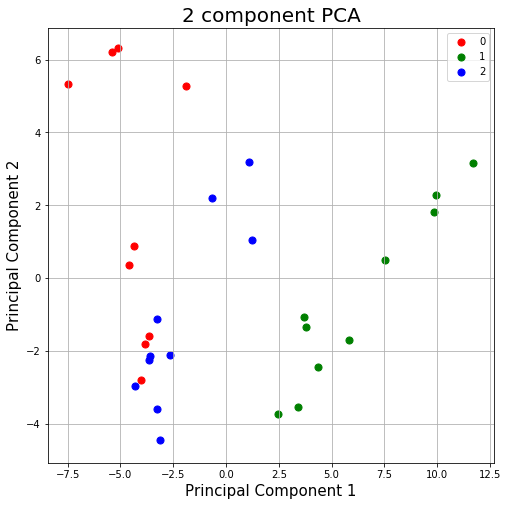

In [27]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep,   'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# KNN

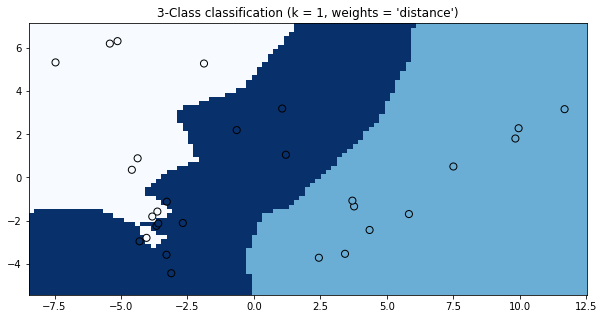

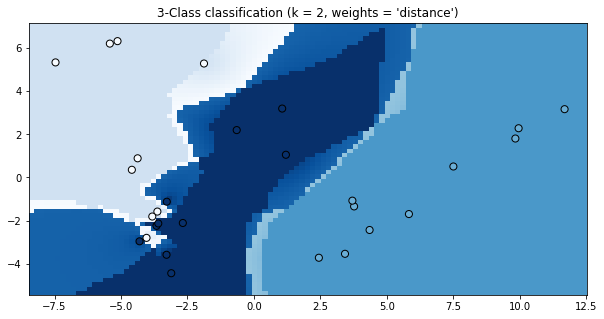

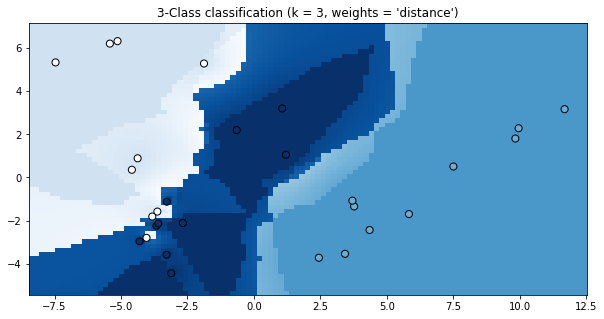

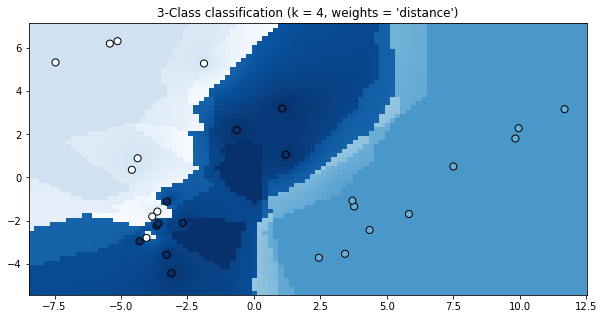

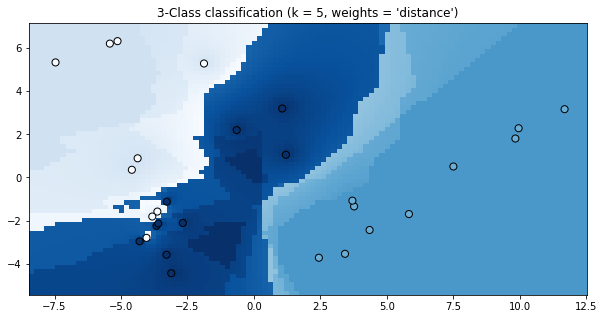

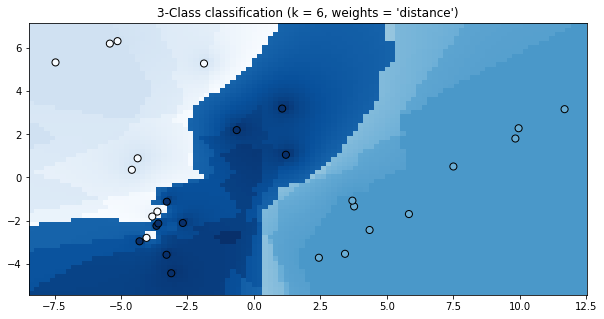

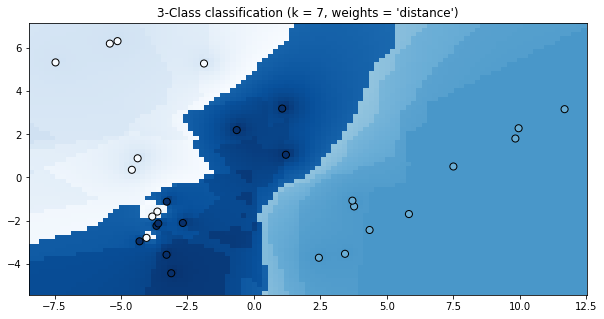

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets


X = finalDf[finalDf.columns.difference(["label"])].values
y = finalDf["label"]

h= 0.2

# Create color maps
cmap_light = ListedColormap(['C3', 'C2', 'C0'])
cmap_bold  = ListedColormap(['r', 'g', 'b'])

for num_NN in range(1, 8):
    # Training
    weights="distance"
    clf = neighbors.KNeighborsClassifier(num_NN, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    

    # Inference
    mesh_predict = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    mesh_labels = np.argmax(mesh_predict, axis=1)
    mesh_proba = mesh_predict[np.arange(len(mesh_predict)), mesh_labels]

    mesh_labels = mesh_labels.reshape(xx.shape)
    mesh_proba = mesh_proba.reshape(xx.shape)

    # Put the result into a color plot
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(xx, yy, mesh_labels+mesh_proba, cmap=cm.Blues)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.Blues,
                edgecolor='k', s=50)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (num_NN, weights))

    plt.show()

# Accuracy calculation

Performs KFold for each differents PCA dimensions.

In [15]:
num_splits = 5

In [16]:
# Dic for results
dic_results = {}

for n_components in range(2, 20):
    #print("\nNum components", n_components)
    for K in range(1, 10):
        kf = KFold(n_splits=num_splits)
        acc_tot = 0.0
        for train_index, test_index in kf.split(X):
            # Split train test
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # PCA on train
            pca = PCA(n_components=n_components)
            pcs_train = pca.fit_transform(X_train)
            pcs_test = pca.transform(X_test)

            # Clf KNN
            clf = neighbors.KNeighborsClassifier(K, weights="distance")
            clf.fit(pcs_train, y_train)

            # Make predictions
            y_preds = clf.predict(pcs_test)
            acc_tot += accuracy_score(y_test, y_preds)

        acc = acc_tot / num_splits
        #print("K={} | Accuracy={}".format(K, acc))
        
        if not K in dic_results:
            dic_results[K] = {"n_components":n_components, "accuracy":acc}
        elif dic_results[K]["accuracy"] < acc:
            dic_results[K] = {"n_components":n_components, "accuracy":acc}

for key, val in dic_results.items():
    print("K={} | {}".format(key, val))

K=1 | {'n_components': 3, 'accuracy': 0.17333333333333334}
K=2 | {'n_components': 3, 'accuracy': 0.17333333333333334}
K=3 | {'n_components': 3, 'accuracy': 0.13999999999999999}
K=4 | {'n_components': 10, 'accuracy': 0.13999999999999999}
K=5 | {'n_components': 3, 'accuracy': 0.10666666666666666}
K=6 | {'n_components': 11, 'accuracy': 0.13999999999999999}
K=7 | {'n_components': 18, 'accuracy': 0.13999999999999999}
K=8 | {'n_components': 9, 'accuracy': 0.10666666666666666}
K=9 | {'n_components': 10, 'accuracy': 0.10666666666666666}


In [23]:
from sklearn.model_selection import cross_validate
pca = PCA(n_components=3)
X = pca.fit_transform(X)
num_splits = 5 
scoring = ['accuracy', 'f1_macro']
clf = neighbors.KNeighborsClassifier(2, weights="distance")
scores = cross_validate(clf, X, y, cv=5, scoring=scoring)
for key in scores:
    print(key+' : '+str(scores[key].mean()))

fit_time : 0.000537252426147461
score_time : 0.0021900177001953126
test_accuracy : 0.27999999999999997
test_f1_macro : 0.1961904761904762


/home/gautier/anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gautier/anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gautier/anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gautier/anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

# Predictions

In [6]:
PATH_TEST       = "../data/test.csv"
PATH_TEST_PREDS = "../data//test_predict.csv"
PATH_OUT        = "../data/preds_KNN.csv"

In [7]:
full_labels = pd.read_csv(PATH_TEST)["full_label"]
df_test     = pd.read_csv(PATH_TEST_PREDS)
X_to_pred   = df_test.values

In [8]:
# Apply PCA
pca = PCA(n_components=4)
X = pca.fit_transform(X)
X_to_pred = pca.transform(X_to_pred)

In [12]:
clf = neighbors.KNeighborsClassifier(2, weights="distance").fit(X, y)

In [13]:
preds = clf.predict(X_to_pred)

In [14]:
proba = clf.predict_proba(X_to_pred)

In [15]:
df_predictions = pd.DataFrame()
df_predictions["full_label"] = full_labels
df_predictions["predicted"] = preds
df_predictions["proba_0"] = proba[:,0]
df_predictions["proba_1"] = proba[:,1]
df_predictions["proba_2"] = proba[:,2]

In [17]:
df_predictions.to_csv(PATH_OUT, index=False)